In [1]:
%matplotlib inline

In [2]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

/Users/bjackson/opt/anaconda3/envs/Experiments_with_KBONUS/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/bjackson/.lightkurve/cache. Please move all the files in the legacy directory /Users/bjackson/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [3]:
polyorder = 3

In [4]:
period, t0 = 2.0451826,	54955.136772
# Obtain the Kepler TPF
tpf = lk.search_targetpixelfile("KIC 10619109", mission="kepler")[4].download()
# Make a light curve from all the pixels in the aperture
lc = tpf.to_lightcurve().normalize()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

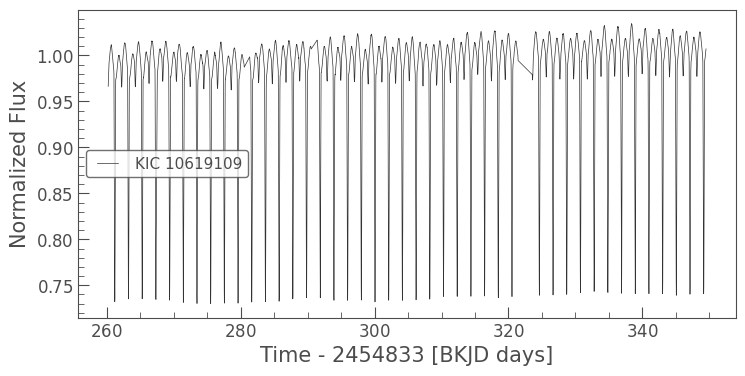

In [5]:
lc.plot()

In [6]:
# We need the pixel time-series and errors
pix = tpf.flux[:, np.ones(tpf.flux.shape[1:], bool)].value
pix_err = tpf.flux_err[:, np.ones(tpf.flux.shape[1:], bool)].value

# We'll make some vectors to detrend against

# Polynomial in time
t = lc.time.value
P = [(t - t.mean())/(t.max() - t.min()) ** idx for idx in range(polyorder + 1)]

# Pos corr from Kepler pipeline
C = np.nan_to_num([tpf.pos_corr1, tpf.pos_corr2, tpf.pos_corr1*tpf.pos_corr2])

# Polynomial in Flux
F = [lc.flux.value**2, lc.flux.value, np.ones(len(lc))]

# Make a design matrix
A = np.vstack([F, P, C]).T

# We're going to fit each segment of the time-series separately. We'll break the time-series up at any points where there are at least 10 skipped cadences.
dt = np.diff(tpf.time.value)
dt /= np.median(dt)
splits = np.where(dt > 10)[0]
model = []
for X, y, ye in zip(np.array_split(A, splits), np.array_split(pix, splits), np.array_split(pix_err, splits)):
    # This function fits the model
    def fit_weights(k):
        return np.asarray([np.linalg.solve(X[k[pdx]].T.dot(X[k[pdx]]/ye[k[pdx], pdx, None]**2) + np.diag(1/(np.ones(X.shape[1]) * 1e5**2)), X[k[pdx]].T.dot(y[k[pdx], pdx]/ye[k[pdx], pdx]**2)) for pdx in range(pix.shape[1])]).T
    if len(y) > 30:
        # We create a mask to remove outliers and iterate the fit
        pixel_mask = np.ones(y.shape, bool).T
        w = fit_weights(pixel_mask)
        pixel_mask = ~sigma_clip(y - X.dot(w), axis=0, sigma=6).mask.T
        w = fit_weights(pixel_mask)
        pixel_mask = ~sigma_clip(y - X.dot(w), axis=0, sigma=3).mask.T
        w = fit_weights(pixel_mask)
        model.append(X.dot(w))
    else:
        model.append(np.ones(y.shape) * np.nan)
model = np.vstack(model)

[Text(0.5, 0, 'Time [BKJD]'), Text(0, 0.5, 'Pixel Time Series'), []]

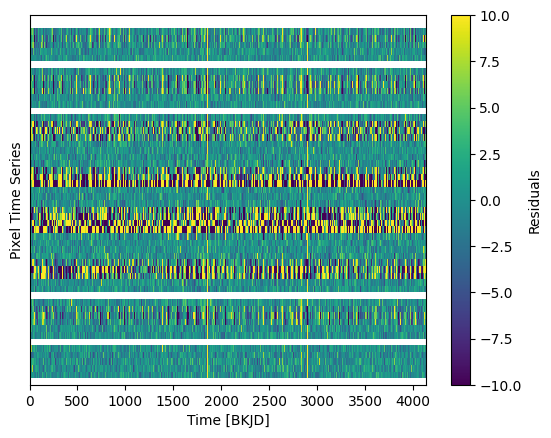

In [7]:
# Now we can look at the residuals
fig, ax = plt.subplots()
im = ax.pcolormesh(pix.T - model.T, vmin=-10, vmax=10)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Residuals")
ax.set(xlabel="Time [BKJD]", ylabel="Pixel Time Series", yticks=[])

[Text(0.5, 0, 'Phase'), Text(0, 0.5, 'Pixel Time Series'), []]

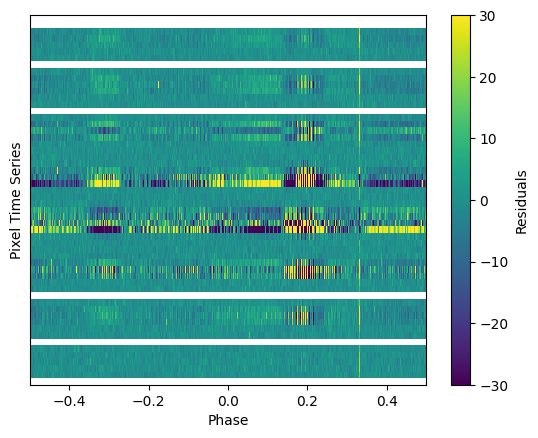

In [8]:
# annd as a function of phase
phase = ((lc.time.value - t0) % period) / period
phase[phase > 0.5] -= 1
s = np.argsort(phase)
fig, ax = plt.subplots()
im = ax.pcolormesh(phase[s], np.arange(pix.shape[1]), (pix.T - model.T)[:, s], vmin=-30, vmax=30)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Residuals")
ax.set(xlabel="Phase", ylabel="Pixel Time Series", yticks=[])